In [1]:
# from IPython.core.display import display,HTML
# display(HTML('<style> div.prompt {display:default} </style>'))

In [2]:
import os, importlib, sys, time, glob

In [3]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
import ladyns as ldn
import ladyns.inference as inf
import ladyns.optimize.core as core

In [6]:
importlib.reload(ldn)
importlib.reload(inf)
importlib.reload(core)

<module 'ladyns.optimize.core' from '/home/hbong/miniconda3/lib/python3.7/site-packages/ladyns/optimize/core.cpython-37m-x86_64-linux-gnu.so'>

In [7]:
def adj_sign(precision, correlation):
    temp_sign = np.cumprod(np.concatenate([
        np.ones(correlation.shape[:-2]+(1,)),
        np.sign(np.sign(correlation[...,np.arange(0, num_time-1),
                                   np.arange(1,num_time)])+0.5),
        np.ones(correlation.shape[:-2]+(1,)),
        np.sign(np.sign(correlation[...,np.arange(num_time, 2*num_time-1),
                                    np.arange(num_time+1, 2*num_time)])+0.5)
    ], -1), -1)

    correlation = correlation * temp_sign[...,None,:] * temp_sign[...,:,None]
    precision = precision * temp_sign[...,None,:] * temp_sign[...,:,None]
    
    temp_sign = np.concatenate([
        np.ones(correlation.shape[:-2]+(num_time,)),
        (-1) * np.sign(np.sign(np.sum(precision[...,:num_time,num_time:], -2))+0.5)], -1)
    
    correlation = correlation * temp_sign[...,None,:] * temp_sign[...,:,None]
    precision = precision * temp_sign[...,None,:] * temp_sign[...,:,None]
    
    return precision, correlation

# 0. simulation from model + LFP

In [66]:
save_dir = "../temp"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## load data

In [67]:
data_dir = "../data/"
file_name = ['lfp_bred_1.mat', 'lfp_bred_2.mat', 'lfp_bred_3.mat']
rec_time = [0, 0.5]

In [68]:
data = [
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['v4_bred']
                    for fname in file_name], 0)[:,:,:100:2].T,
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['pfc_bred']
                    for fname in file_name], 0)[:,:,:100:2].T]

In [69]:
data[0].shape, data[1].shape

((50, 25, 3000), (50, 25, 3000))

In [70]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[0]
obs_trial = data[0].shape[2]

## load LaDynS run on data

In [71]:
result_exp = np.load('%s/result_exp.npz'%save_dir)
Sigma_exp = result_exp['Sigma_est']
weight_exp = result_exp['weight_est']

## cross precision

In [72]:
num_blobs = 3

In [73]:
times = np.array([[1, 1, 12], [21, 18, 6], [32, 37, 9]])

In [74]:
H0 = np.zeros((times.shape[0], num_time, num_time))
for i, (time_0, time_1, duration) in enumerate(times):
    H0[i, time_0:time_0+duration, time_1:time_1+duration] \
    = np.abs(np.arange(duration)-np.arange(duration)[:,None]) < 2

Text(0.5, 0, 'series 2 at time $s$')

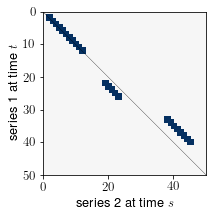

In [75]:
plt.figure(figsize=(3,3))
ldn.imshow(np.sum(H0, 0), time=[0,50], identity=True, vmax=1)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

## latent direction

In [76]:
mu = [np.mean(dat, -1) for dat in data]
covs = [
    np.matmul(dat - m[...,None], dat - m[...,None], axes=[(1,2),(2,1),(1,2)])/obs_trial
    for dat, m in zip(data, mu)]

In [77]:
weights_exp = [np.array(weight_exp[:num_time]),
               np.array(weight_exp[num_time:])]
betas_exp = [(cov @ w[...,None])[...,0] for cov ,w in zip(covs, weights_exp)]

## latent precision

In [78]:
sighat = Sigma_exp.copy()
sighat_1 = sighat[:num_time,:num_time]
sighat_2 = sighat[num_time:,num_time:]

In [79]:
Y_mm_1 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_1[np.arange(1,num_time), np.arange(0,num_time-1)])))])
Y_mm_2 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_2[np.arange(1,num_time), np.arange(0,num_time-1)])))])

In [80]:
sigmm_1 = np.exp(-(np.square(Y_mm_1[:,None] - Y_mm_1[None,:])/2))
sigmm_2 = np.exp(-(np.square(Y_mm_2[:,None] - Y_mm_2[None,:])/2))

In [81]:
precs_auto = [linalg.inv(S + 0.5 * np.eye(num_time))
              for S in [sigmm_1, sigmm_2]] 

In [82]:
snr = 0.010
prec_latent = np.array(np.block([
    [precs_auto[0]+snr*np.eye(num_time)*np.sum(H0,(0,2)), -snr*np.sum(H0,0)],
    [-snr*np.sum(H0,0).T, precs_auto[1]+snr*np.eye(num_time)*np.sum(H0,(0,1))]
]))

In [83]:
cov_latent = linalg.inv(prec_latent)
sd_latent = np.sqrt(np.diag(cov_latent))
corr_latent = cov_latent / sd_latent / sd_latent[:,None]
prec_latent = np.linalg.inv(corr_latent)
chol_latent = linalg.cholesky(corr_latent)

# 1. analysis on simulated estimation 

In [19]:
snrs = np.array([0.002, 0.004, 0.006, 0.008, 0.010])

In [20]:
num_bst = 200

In [21]:
num_sim = np.min([len(glob.glob("%s/result_sim_%.1d_*.npz"%(save_dir, i))) 
                  for i, snr in enumerate(snrs)])

In [22]:
num_sim

60

In [23]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 0.5), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [24]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [25]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[3]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.025118864315095805, 0.0, 0.5, 0.0)

In [26]:
lambda_graph = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

## true desparsified precision

In [84]:
IOmega_latent = corr_latent.copy()
Omega_latent = np.linalg.inv(IOmega_latent)

In [85]:
core.glasso(Omega_latent, IOmega_latent, corr_latent, lambda_graph)

In [86]:
dspr_latent = 2*Omega_latent - Omega_latent @ corr_latent @ Omega_latent

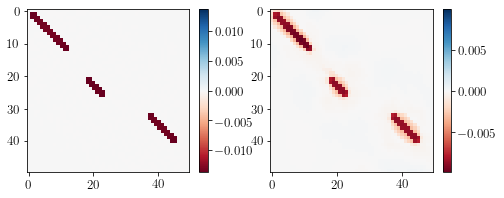

In [87]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1); ldn.imshow(prec_latent[:num_time,num_time:]); plt.colorbar()
plt.subplot(1,2,2); ldn.imshow(dspr_latent[:num_time,num_time:]); plt.colorbar()

## load simulation results

In [31]:
Omegas_sim = np.zeros((len(snrs), num_sim, 2*num_time, 2*num_time))
Sigmas_sim = np.zeros((len(snrs), num_sim, 2*num_time, 2*num_time))

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"
                         %(save_dir,iter_snr,iter_sim))
        Omega_est = result["Omega_est"]; Sigma_est=result["Sigma_est"]

        Omegas_sim[iter_snr, iter_sim] = Omega_est
        Sigmas_sim[iter_snr, iter_sim] = Sigma_est

Omegas_perm = result["Omegas_perm"]
Sigmas_perm = result["Sigmas_perm"]

## simulation result

In [32]:
Omegas_sim, Sigmas_sim = adj_sign(Omegas_sim, Sigmas_sim)

In [33]:
dsprs_sim = 2*Omegas_sim - Omegas_sim @ Sigmas_sim @ Omegas_sim
std_dspr_sim = np.std(dsprs_sim, 1)

In [35]:
dsprs_perm = 2*Omegas_perm - Omegas_perm @ Sigmas_perm @ Omegas_perm
std_dspr_perm = np.std(dsprs_perm, 0)

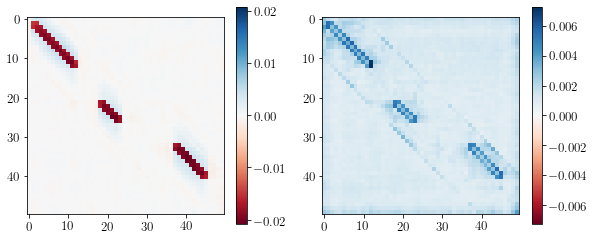

In [51]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1); ldn.imshow(np.mean(dsprs_sim[-1], 0)[:num_time,num_time:]); plt.colorbar()
plt.subplot(1,3,2); ldn.imshow(np.std(dsprs_sim[-1], 0)[:num_time,num_time:]); plt.colorbar()

# check normality (Section S5)

In [41]:
x_grid = np.linspace(-4, 4, 41)
dnorm_grid = stats.norm(0,1).pdf(x_grid)

In [42]:
rand_inds = np.concatenate([
    np.random.choice(np.where(np.sum(H0,0).flatten() == 0)[0], 3, False),
    np.random.choice(np.where(np.sum(H0,0).flatten() != 0)[0], 3, False)
])

Text(0, 0.5, 'connection')

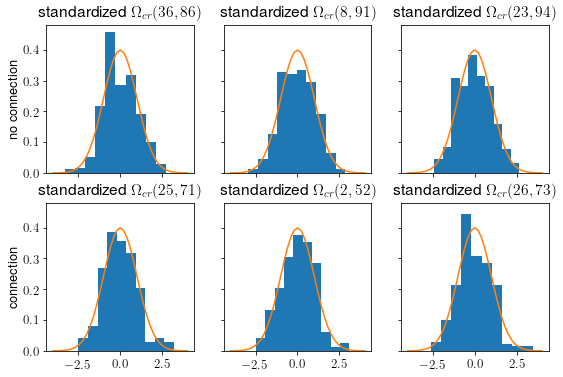

In [43]:
fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=[9.0, 6.0],
                         facecolor='white')
for label, ax in zip(rand_inds, axes.flatten()):
    ax.hist(((dsprs_sim[...,int(label/num_time),num_time+label%num_time]
              - np.mean(dsprs_sim,1)[:,None,int(label/num_time),num_time+label%num_time])
             / std_dspr_sim[:,None,int(label/num_time),num_time+label%num_time]).flatten(),
             density=True)
    ax.plot(x_grid, dnorm_grid)
    ax.set_title(r'standardized $\Omega_{cr}(%d,%d)$'
                  %(int(label/num_time),num_time+label%num_time))
axes[0,0].set_ylabel('no connection')
axes[1,0].set_ylabel('connection')

Text(0.5, 0, 'quantiles of $N(0,1)$')

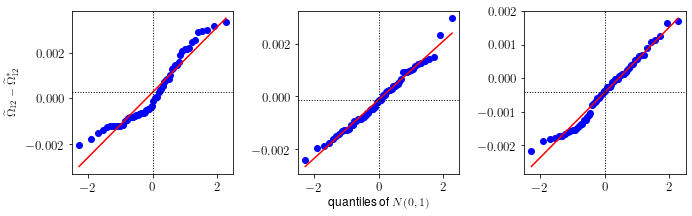

In [45]:
fig, axes = plt.subplots(1, 3, #sharey=True, sharex=True,
                         figsize=[11.0, 3.0], facecolor='white')
plt.subplots_adjust(wspace=0.4)
for label, ax in zip(rand_inds[:3], axes.flatten()):
    _, (a, b, r) = \
    stats.probplot((dsprs_sim[-1,:,int(label/num_time),num_time+label%num_time]
                    - dspr_latent[int(label/num_time),num_time+label%num_time]).flatten(),
                   dist='norm', fit=True, plot=ax)
    ax.axvline(0, color='black', linestyle=":", linewidth=1)
    ax.axhline(b, color='black', linestyle=":", linewidth=1)
    # ax.plot((-3,3),(-3,3), color='black')
    ax.set_xlabel(r''); ax.set_ylabel(r'')
    ax.set_title('')
    
axes[0].set_ylabel(r'$\widetilde\Omega_{12} - \widetilde\Omega_{12}^*$', fontsize=12)
axes[1].set_xlabel(r'quantiles of $N(0,1)$', fontsize=12)

#     ax.set_title(r'Q-Q $\Omega_{12}^{(%d,%d)}$ vs. norm'
#                   %(int(label/num_time),num_time+label%num_time))
# axes[0,0].set_ylabel('no connection')
# axes[1,0].set_ylabel('connection')

# 3. FDR from estimated variance

## p-values

In [313]:
pvals_est = np.full((len(snrs), num_sim, num_time, num_time), 0.5)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"%(save_dir,iter_snr, iter_sim))
        Omega_est=result["Omega_est"]; Sigma_est=result["Sigma_est"]
        Omegas_perm=result["Omegas_perm"]; Sigmas_perm=result["Sigmas_perm"]

        dspr_est = 2*Omega_est - Omega_est@Sigma_est@Omega_est
        dsprs_perm = 2*Omegas_perm - Omegas_perm@Sigmas_perm@Omegas_perm
        dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
        dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                         / np.std(dsprs_perm[:,:num_time,num_time:],0))
        
        temp = np.argsort(np.concatenate([
            np.abs(dist_dspr_est[roi]),
            np.abs(dist_dspr_perm[:,roi]).flatten()]))

        ranks = np.empty_like(temp)
        ranks[temp] = np.cumsum(temp > np.sum(roi))
        
        pvals_est[iter_snr, iter_sim][roi] = 1-(ranks[:np.sum(roi)]/len(temp) - 1/(2*len(temp)))        
#         pvals_perm[iter_snr, iter_sim] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est)), 1e-10, 1-1e-10)

## get discoveries

In [314]:
alphas = np.linspace(0, 0.1, 11)
roi = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [315]:
rejs_STAR = np.full((len(snrs), num_sim,) + alphas.shape + (num_time, num_time), False)
rejs_BH = np.full((len(snrs), num_sim,) + alphas.shape + (num_time, num_time), False)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write('%d-%d-th simulation\n'%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()  
        
        # STAR process
        _, _, _, rej_sim = \
        inf.STAR_seq_step(pvals_est[iter_snr, iter_sim], prop_carve=0.05, alphas=alphas,
                          sigma=1.5, mux_init=-np.log(0.01), roi=roi)
        rejs_STAR[iter_snr, iter_sim] = rej_sim
        
        # BH process
        p_sorted = np.concatenate([[0], np.sort(pvals_est[iter_snr, iter_sim, roi])])
        for iter_alpha, alpha in enumerate(alphas):
            k_hat = np.max(np.where(np.linspace(0, alpha, np.sum(roi)+1) >= p_sorted))        
            rejs_BH[iter_snr, iter_sim, iter_alpha] \
            = pvals_est[iter_snr, iter_sim] <= k_hat * alpha / np.sum(roi)

## get rejected blobs

In [316]:
rej_blobs_STAR = np.zeros((len(snrs), num_sim,) + alphas.shape + (num_time, num_time))
num_blobs_STAR = np.zeros((len(snrs), num_sim,) + alphas.shape)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        for iter_alpha, alpha in enumerate(alphas):
            mask_cp = rejs_STAR[iter_snr, iter_sim, iter_alpha].copy()
            iter_blob = 0
            while np.any(mask_cp):
                iter_blob += 1
                queue = [tuple(np.transpose(np.where(mask_cp))[0])]
                mask_cp[queue[0]] = False
                while len(queue) > 0:
                    cur = queue.pop(0)
                    rej_blobs_STAR[iter_snr, iter_sim, iter_alpha,
                                        cur[0], cur[1]] = iter_blob
                    if cur[0] > 0:
                        if mask_cp[cur[0]-1, cur[1]]:
                            queue.append((cur[0]-1, cur[1]))
                            mask_cp[cur[0]-1, cur[1]] = False
                    if cur[0] < num_time-1:
                        if mask_cp[cur[0]+1, cur[1]]:
                            queue.append((cur[0]+1, cur[1]))
                            mask_cp[cur[0]+1, cur[1]] = False
                    if cur[1] > 0:
                        if mask_cp[cur[0], cur[1]-1]:
                            queue.append((cur[0], cur[1]-1))
                            mask_cp[cur[0], cur[1]-1] = False
                    if cur[1] < num_time-1:
                        if mask_cp[cur[0], cur[1]+1]:
                            queue.append((cur[0], cur[1]+1))
                            mask_cp[cur[0], cur[1]+1] = False
            num_blobs_STAR[iter_snr, iter_sim, iter_alpha] = iter_blob

## calculate fdrs

In [317]:
# H0_sm = np.abs(np.mean(dsprs_sim,1)[-2:-1,:num_time,num_time:])>0.002
H0_sm = np.array([np.sum(H0,0) > 0 for _ in enumerate(snrs)])
# H0_sm = np.mean(np.abs(Omegas_sim) > 0, 1)[:,:num_time,num_time:] > 0.95

In [318]:
H0_sm.shape

(5, 50, 50)

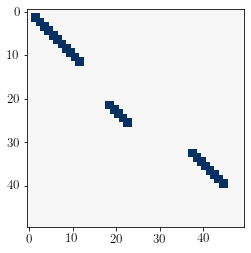

In [319]:
ldn.imshow(H0_sm[0])

In [321]:
fdps_STAR = np.sum(rejs_STAR > H0_sm[:,None,None], (-2,-1)) \
           / np.maximum(np.sum(rejs_STAR, (-2,-1)), 1)   

fnps_STAR = np.sum(rejs_STAR < H0_sm[:,None,None], (-2,-1)) \
               / np.maximum(np.sum(H0_sm,(-1,-2)), 1)[:,None,None]

fdps_BH = np.sum(rejs_BH > H0_sm[:,None,None], (-2,-1)) \
           / np.maximum(np.sum(rejs_BH, (-2,-1)), 1)  

fnps_BH = np.sum(rejs_BH < H0_sm[:,None,None], (-2,-1)) \
            / np.maximum(np.sum(H0_sm,(-1,-2)), 1)[:,None,None]

In [322]:
fcds_STAR = num_blobs_STAR.copy()
for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        for iter_alpha, _ in enumerate(alphas):
            fcds_STAR[iter_snr, iter_sim, iter_alpha] -= np.sum(np.unique(
                rej_blobs_STAR[iter_snr, iter_sim, iter_alpha, np.any(H0,0)])> 0)
        
fcdps_STAR = fcds_STAR / np.maximum(num_blobs_STAR, 1)

In [323]:
fcnps_STAR = np.sum(np.all(
    np.logical_or((rejs_STAR[...,None,:,:] < H0), np.logical_not(H0))
    , (-2,-1)), -1) /np.maximum(H0.shape[0], 1)

## plots

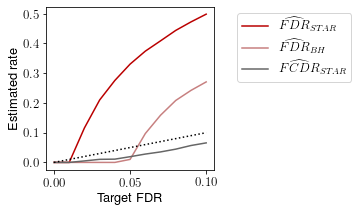

In [325]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fdps_STAR, (0,1)), color=(187/256, 0, 0), label=r"$\widehat{FDR}_{STAR}$")
plt.plot(alphas, np.mean(fdps_BH, (0,1)), color=(200/256, 128/256, 128/256), label=r"$\widehat{FDR}_{BH}$")
plt.plot(alphas, np.mean(fcdps_STAR, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCDR}_{STAR}$")
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"Estimated rate") #; plt.ylim(-0.02, 0.32)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

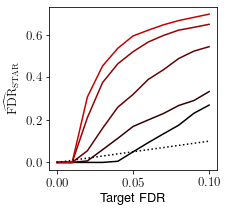

In [524]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fdps_STAR[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FDR}_\mathrm{STAR}$"); #plt.legend()

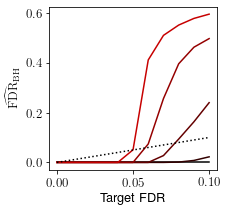

In [525]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fdps_BH[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FDR}_\mathrm{BH}$");# plt.legend()

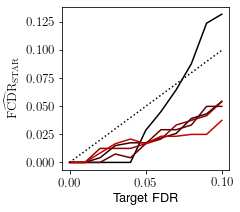

In [526]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcdps_STAR[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FCDR}_\mathrm{STAR}$"); #plt.legend()

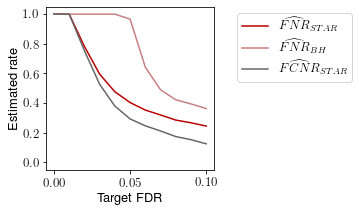

In [329]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fnps_STAR, (0,1)), color=(187/256, 0, 0), label = r"$\widehat{FNR}_{STAR}$")
plt.plot(alphas, np.mean(fnps_BH, (0,1)), color=(200/256, 128/256, 128/256), label=r"$\widehat{FNR}_{BH}$")
plt.plot(alphas, np.mean(fcnps_STAR, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCNR}_{STAR}$")
plt.xlabel(r"Target FDR"); plt.ylabel(r"Estimated rate"); plt.ylim(-0.05,1.05)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

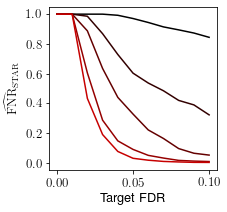

In [527]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fnps_STAR[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FNR}_\mathrm{STAR}$"); #plt.legend()

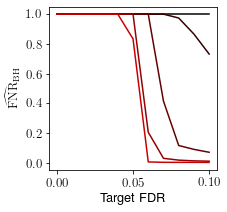

In [528]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fnps_BH[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FNR}_\mathrm{BH}$"); #plt.legend()

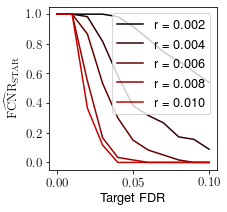

In [529]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcnps_STAR[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"r = %.3f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FCNR}_\mathrm{STAR}$"); plt.legend()

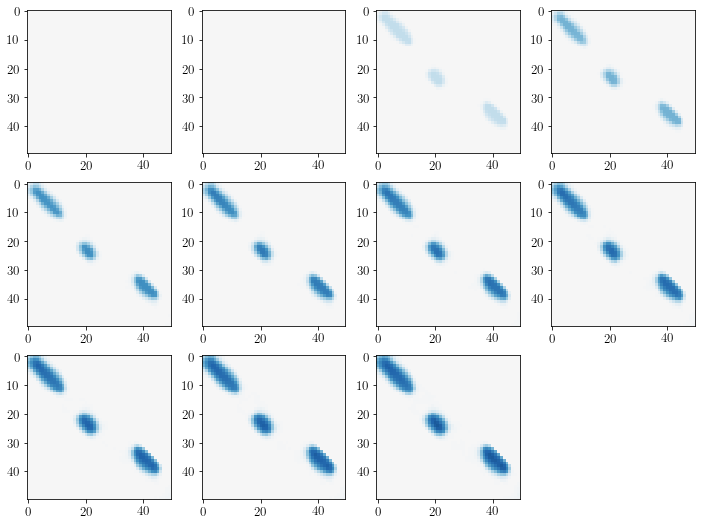

In [333]:
plt.figure(figsize=(12,9))
for iter_alpha, alpha in enumerate(alphas):
    plt.subplot(3, 4, iter_alpha+1)
    ldn.imshow(np.mean(rejs_STAR[:,:,iter_alpha], (0,1)), cmap='RdBu', vmax=1, vmin=-1)

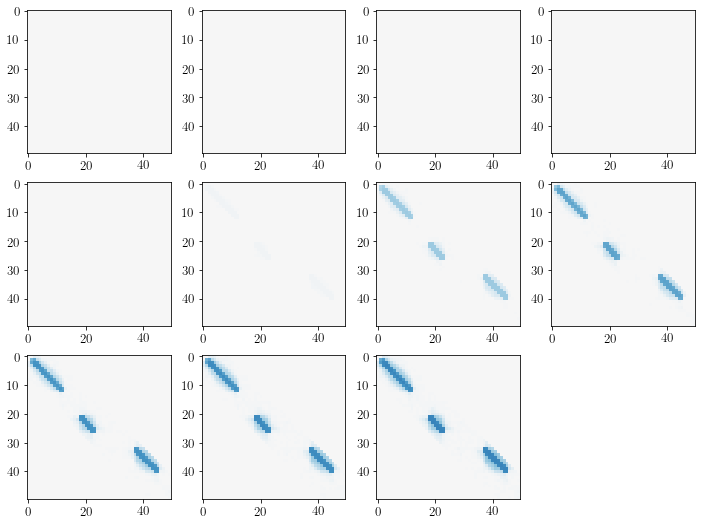

In [334]:
plt.figure(figsize=(12,9))
for iter_alpha, alpha in enumerate(alphas):
    plt.subplot(3, 4, iter_alpha+1)
    ldn.imshow(np.mean(rejs_BH[:,:,iter_alpha], (0,1)), cmap='RdBu', vmax=1, vmin=-1)

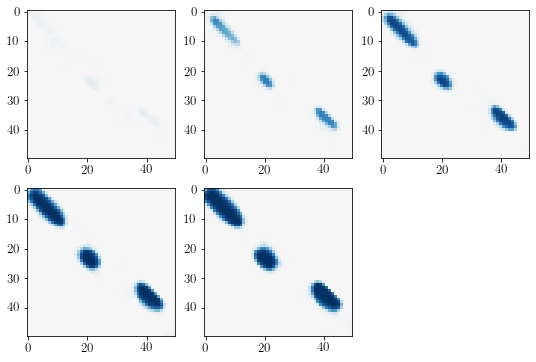

In [335]:
plt.figure(figsize=(9,6))
for iter_snr, snr in enumerate(snrs):
    plt.subplot(2, 3, iter_snr+1)
    ldn.imshow(np.mean(rejs_STAR[iter_snr,:,6], (0)), cmap='RdBu', vmax=1, vmin=-1)

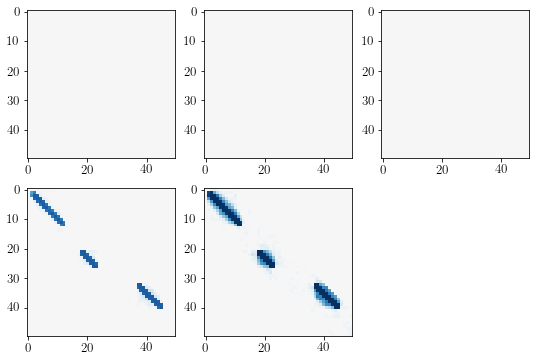

In [336]:
plt.figure(figsize=(9,6))
for iter_snr, snr in enumerate(snrs):
    plt.subplot(2, 3, iter_snr+1)
    ldn.imshow(np.mean(rejs_BH[iter_snr,:,6], (0)), cmap='RdBu', vmax=1, vmin=-1)

# 4. excursion test (Section S4)

In [337]:
ths_nv = 0.05
num_perm = 200

## p-values

In [338]:
pvals_exc_blob = np.full((len(snrs), num_sim, num_blobs), 0.5)
pvals_exc_null = np.full((len(snrs), num_sim), 0.5)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"%(save_dir,iter_snr, iter_sim))
        Omega_est=result["Omega_est"]; Sigma_est=result["Sigma_est"]
        Omegas_perm=result["Omegas_perm"]; Sigmas_perm=result["Sigmas_perm"]

        dspr_est = 2*Omega_est - Omega_est@Sigma_est@Omega_est
        dsprs_perm = 2*Omegas_perm - Omegas_perm@Sigmas_perm@Omegas_perm
        dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
        dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                         / np.std(dsprs_perm[:,:num_time,num_time:],0))
        
        temp = np.argsort(np.concatenate([
            np.abs(dist_dspr_est[roi]),
            np.abs(dist_dspr_perm[:,roi]).flatten()]))

        ranks = np.empty_like(temp)
        ranks[temp] = np.cumsum(temp > np.sum(roi))
        
        pval_est = np.full(dist_dspr_est.shape, 0.5)
        pvals_perm = np.full(dist_dspr_perm.shape, 0.5)
        pval_est[roi] = 1-(ranks[:np.sum(roi)]/len(temp) - 1/(2*len(temp)))
        pvals_perm[:,roi] = 1-(ranks[np.sum(roi):].reshape((num_perm,np.sum(roi)))/len(temp) - 1/(2*len(temp)))
        
        rej_nv_est = pval_est < ths_nv
        rejs_nv_perm = pvals_perm < ths_nv
        
        rb_nv_est = np.zeros((num_time, num_time))
        mask_cp = rej_nv_est.copy(); iter_blob = 0
        while np.any(mask_cp):
            iter_blob += 1
            queue = [tuple(np.transpose(np.where(mask_cp))[0])]
            mask_cp[queue[0]] = False
            while len(queue) > 0:
                cur = queue.pop(0)
                rb_nv_est[cur[0], cur[1]] = iter_blob
                if cur[0] > 0:
                    if mask_cp[cur[0]-1, cur[1]]:
                        queue.append((cur[0]-1, cur[1]))
                        mask_cp[cur[0]-1, cur[1]] = False
                if cur[0] < num_time-1:
                    if mask_cp[cur[0]+1, cur[1]]:
                        queue.append((cur[0]+1, cur[1]))
                        mask_cp[cur[0]+1, cur[1]] = False
                if cur[1] > 0:
                    if mask_cp[cur[0], cur[1]-1]:
                        queue.append((cur[0], cur[1]-1))
                        mask_cp[cur[0], cur[1]-1] = False
                if cur[1] < num_time-1:
                    if mask_cp[cur[0], cur[1]+1]:
                        queue.append((cur[0], cur[1]+1))
                        mask_cp[cur[0], cur[1]+1] = False
        nb_nv_est = iter_blob

        rbs_nv_perm = np.zeros((num_perm, num_time, num_time))
        nbs_nv_perm = np.zeros((num_perm,))
        for iter_perm in range(num_perm):
            mask_cp = rejs_nv_perm[iter_perm].copy(); iter_blob = 0
            while np.any(mask_cp):
                iter_blob += 1
                queue = [tuple(np.transpose(np.where(mask_cp))[0])]
                mask_cp[queue[0]] = False
                while len(queue) > 0:
                    cur = queue.pop(0)
                    rbs_nv_perm[iter_perm, cur[0], cur[1]] = iter_blob
                    if cur[0] > 0:
                        if mask_cp[cur[0]-1, cur[1]]:
                            queue.append((cur[0]-1, cur[1]))
                            mask_cp[cur[0]-1, cur[1]] = False
                    if cur[0] < num_time-1:
                        if mask_cp[cur[0]+1, cur[1]]:
                            queue.append((cur[0]+1, cur[1]))
                            mask_cp[cur[0]+1, cur[1]] = False
                    if cur[1] > 0:
                        if mask_cp[cur[0], cur[1]-1]:
                            queue.append((cur[0], cur[1]-1))
                            mask_cp[cur[0], cur[1]-1] = False
                    if cur[1] < num_time-1:
                        if mask_cp[cur[0], cur[1]+1]:
                            queue.append((cur[0], cur[1]+1))
                            mask_cp[cur[0], cur[1]+1] = False
            nbs_nv_perm[iter_perm] = iter_blob
            
        mrois_nv_perm = np.zeros(num_perm)
        for iter_perm, (pval, rej_b, num_b) \
        in enumerate(zip(pvals_perm, rbs_nv_perm, nbs_nv_perm)):
            rois = np.zeros(int(num_b+1))
            for iter_blob in range(1, int(num_b+1)):
                rois[iter_blob] = np.sum(-np.log(
                    pvals_perm[iter_perm][rej_b == iter_blob]))
            mrois_nv_perm[iter_perm] = np.max(rois)
            
        rois_nv_est = np.zeros(nb_nv_est+1)
        for iter_blob in range(1, nb_nv_est+1):
            rois_nv_est[iter_blob] = np.sum(-np.log(pval_est[rb_nv_est == iter_blob]))
        p_rois_nv = np.mean(rois_nv_est <= mrois_nv_perm[:,None], 0)
        
        rbs_H0 = stats.mode(np.where(H0 * rb_nv_est > 0, rb_nv_est, np.nan)
                 .reshape(num_blobs, -1), 1)[0][:,0].astype(int)
        
        pvals_exc_blob[iter_snr,iter_sim] = p_rois_nv[rbs_H0]
        pvals_exc_null[iter_snr,iter_sim] \
        = np.min(p_rois_nv[~np.isin(np.arange(nb_nv_est+1),rbs_H0)])

Text(0, 0.5, 'Ordered p-values of \n null clusters')

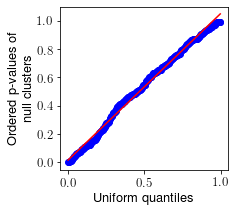

In [369]:
plt.figure(figsize=(3,3))
stats.probplot(pvals_exc_null.flatten(), dist='uniform', fit=False, plot=plt)
plt.title("")
plt.xlabel("Uniform quantiles"); plt.ylabel("Ordered p-values of \n null clusters")

In [382]:
p_nominal = np.linspace(0, 1, 2001)
TPR = np.mean(pvals_exc_blob[...,None] < p_nominal, (1,2))
FPR = np.mean(pvals_exc_null[...,None] < p_nominal, (1))

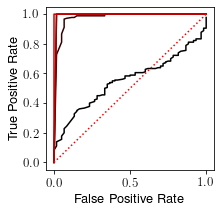

In [515]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(FPR[iter_snr], TPR[iter_snr], color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot([0,1],[0,1], color='red', ls=':')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); #plt.legend()

Text(0, 0.5, 'True Positive Rate')

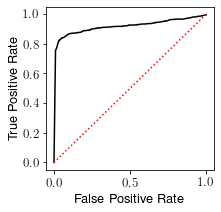

In [361]:
plt.figure(figsize=(3,3))
plt.plot(FPR, TPR, color='black')
plt.plot([0,1],[0,1], color='red', ls=':')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")

In [371]:
np.sum((TPR[1:]+TPR[:-1]) * (FPR[1:]-FPR[:-1]),0) / 2

0.9175481481481481

# 5. STAR + excursion test

In [481]:
rbs_pexc = np.zeros((len(snrs), num_sim,) + alphas.shape + (num_time, num_time))
nbs_pexc = np.zeros((len(snrs), num_sim,) + alphas.shape)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"%(save_dir,iter_snr, iter_sim))
        Omega_est=result["Omega_est"]; Sigma_est=result["Sigma_est"]
        Omegas_perm=result["Omegas_perm"]; Sigmas_perm=result["Sigmas_perm"]

        dspr_est = 2*Omega_est - Omega_est@Sigma_est@Omega_est
        dsprs_perm = 2*Omegas_perm - Omegas_perm@Sigmas_perm@Omegas_perm
        dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
        dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                         / np.std(dsprs_perm[:,:num_time,num_time:],0))
        
        temp = np.argsort(np.concatenate([
            np.abs(dist_dspr_est[roi]),
            np.abs(dist_dspr_perm[:,roi]).flatten()]))

        ranks = np.empty_like(temp)
        ranks[temp] = np.cumsum(temp > np.sum(roi))
        
        pval_est = np.full(dist_dspr_est.shape, 0.5)
        pvals_perm = np.full(dist_dspr_perm.shape, 0.5)
        pval_est[roi] = 1-(ranks[:np.sum(roi)]/len(temp) - 1/(2*len(temp)))
        pvals_perm[:,roi] = 1-(ranks[np.sum(roi):].reshape((num_perm,np.sum(roi)))/len(temp) - 1/(2*len(temp)))
        
        rej_nv_est = pval_est < ths_nv
        rejs_nv_perm = pvals_perm < ths_nv
        
        rb_nv_est = np.zeros((num_time, num_time))
        mask_cp = rej_nv_est.copy(); iter_blob = 0
        while np.any(mask_cp):
            iter_blob += 1
            queue = [tuple(np.transpose(np.where(mask_cp))[0])]
            mask_cp[queue[0]] = False
            while len(queue) > 0:
                cur = queue.pop(0)
                rb_nv_est[cur[0], cur[1]] = iter_blob
                if cur[0] > 0:
                    if mask_cp[cur[0]-1, cur[1]]:
                        queue.append((cur[0]-1, cur[1]))
                        mask_cp[cur[0]-1, cur[1]] = False
                if cur[0] < num_time-1:
                    if mask_cp[cur[0]+1, cur[1]]:
                        queue.append((cur[0]+1, cur[1]))
                        mask_cp[cur[0]+1, cur[1]] = False
                if cur[1] > 0:
                    if mask_cp[cur[0], cur[1]-1]:
                        queue.append((cur[0], cur[1]-1))
                        mask_cp[cur[0], cur[1]-1] = False
                if cur[1] < num_time-1:
                    if mask_cp[cur[0], cur[1]+1]:
                        queue.append((cur[0], cur[1]+1))
                        mask_cp[cur[0], cur[1]+1] = False
        nb_nv_est = iter_blob

        rbs_nv_perm = np.zeros((num_perm, num_time, num_time))
        nbs_nv_perm = np.zeros((num_perm,))
        for iter_perm in range(num_perm):
            mask_cp = rejs_nv_perm[iter_perm].copy(); iter_blob = 0
            while np.any(mask_cp):
                iter_blob += 1
                queue = [tuple(np.transpose(np.where(mask_cp))[0])]
                mask_cp[queue[0]] = False
                while len(queue) > 0:
                    cur = queue.pop(0)
                    rbs_nv_perm[iter_perm, cur[0], cur[1]] = iter_blob
                    if cur[0] > 0:
                        if mask_cp[cur[0]-1, cur[1]]:
                            queue.append((cur[0]-1, cur[1]))
                            mask_cp[cur[0]-1, cur[1]] = False
                    if cur[0] < num_time-1:
                        if mask_cp[cur[0]+1, cur[1]]:
                            queue.append((cur[0]+1, cur[1]))
                            mask_cp[cur[0]+1, cur[1]] = False
                    if cur[1] > 0:
                        if mask_cp[cur[0], cur[1]-1]:
                            queue.append((cur[0], cur[1]-1))
                            mask_cp[cur[0], cur[1]-1] = False
                    if cur[1] < num_time-1:
                        if mask_cp[cur[0], cur[1]+1]:
                            queue.append((cur[0], cur[1]+1))
                            mask_cp[cur[0], cur[1]+1] = False
            nbs_nv_perm[iter_perm] = iter_blob
            
        mrois_nv_perm = np.zeros(num_perm)
        for iter_perm, (pval, rej_b, num_b) \
        in enumerate(zip(pvals_perm, rbs_nv_perm, nbs_nv_perm)):
            rois = np.zeros(int(num_b+1))
            for iter_blob in range(1, int(num_b+1)):
                rois[iter_blob] = np.sum(-np.log(
                    pvals_perm[iter_perm][rej_b == iter_blob]))
            mrois_nv_perm[iter_perm] = np.max(rois)
            
        rois_nv_est = np.zeros(nb_nv_est+1)
        for iter_blob in range(1, nb_nv_est+1):
            rois_nv_est[iter_blob] = np.sum(-np.log(pval_est[rb_nv_est == iter_blob]))
        p_rois_nv = np.mean(rois_nv_est <= mrois_nv_perm[:,None], 0)
        
        for iter_alpha, alpha in enumerate(alphas):
            rb_STAR = np.array(
                [rej_blobs_STAR[iter_snr,iter_sim,iter_alpha] == i+1
                 for i in range(int(num_blobs_STAR[iter_snr,iter_sim,iter_alpha]))]).reshape([-1,num_time,num_time])
            id_STAR = stats.mode(np.where(rb_STAR * rb_nv_est > 0, rb_nv_est, np.nan)
                 .reshape([-1,num_time**2]), 1)[0].reshape((-1,1))[:,0]
            id_STAR = np.where(np.isnan(id_STAR), -1, id_STAR.astype(int))
            p_pexc = np.where(id_STAR == -1, 1, p_rois_nv[id_STAR])
            
            nbs_pexc[iter_snr,iter_sim,iter_alpha] = np.sum(p_pexc < 0.05)
            rbs_pexc[iter_snr,iter_sim,iter_alpha] = np.sum(rb_STAR[p_pexc < 0.05] * np.arange(1,np.sum(p_pexc < 0.05)+1)[:,None,None], 0)

## calculate fdrs

In [501]:
rejs_pexc = np.minimum(rbs_pexc, 1)

In [502]:
fdps_pexc = np.sum(rejs_pexc > H0_sm[:,None,None], (-2,-1)) \
           / np.maximum(np.sum(rejs_post_exc, (-2,-1)), 1)   

fnps_pexc = np.sum(rejs_pexc < H0_sm[:,None,None], (-2,-1)) \
               / np.maximum(np.sum(H0_sm,(-1,-2)), 1)[:,None,None]

In [503]:
fcds_pexc = nbs_pexc.copy()
for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        for iter_alpha, _ in enumerate(alphas):
            fcds_pexc[iter_snr, iter_sim, iter_alpha] -= np.sum(np.unique(
                rbs_pexc[iter_snr, iter_sim, iter_alpha, np.any(H0,0)])> 0)
        
fcdps_pexc = fcds_pexc / np.maximum(nbs_pexc, 1)

In [504]:
fcnps_pexc = np.sum(np.all(
    np.logical_or((rejs_pexc[...,None,:,:] < H0), np.logical_not(H0))
    , (-2,-1)), -1) /np.maximum(H0.shape[0], 1)

## plots

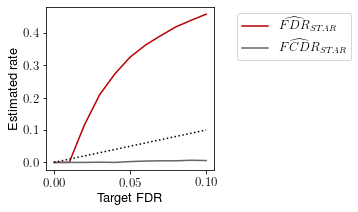

In [507]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fdps_pexc, (0,1)), color=(187/256, 0, 0), label=r"$\widehat{FDR}_{STAR}$")
plt.plot(alphas, np.mean(fcdps_pexc, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCDR}_{STAR}$")
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"Estimated rate") #; plt.ylim(-0.02, 0.32)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

Text(0, 0.5, '$\\widehat{\\mathrm{FCDR}}_\\mathrm{STAR}$')

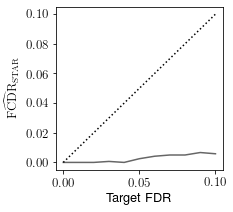

In [508]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fcdps_pexc, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCNR}_{STAR}$")
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat{\mathrm{FCDR}}_\mathrm{STAR}$")

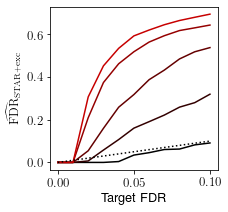

In [523]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fdps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FDR}_\mathrm{STAR+exc}$"); #plt.legend()

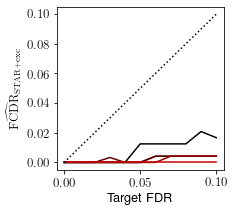

In [522]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcdps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FCDR}_\mathrm{STAR+exc}$"); #plt.legend()

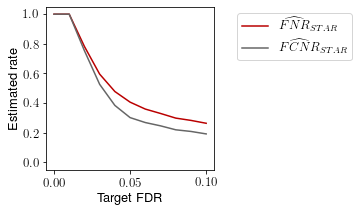

In [511]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fnps_pexc, (0,1)), color=(187/256, 0, 0), label = r"$\widehat{FNR}_{STAR}$")
plt.plot(alphas, np.mean(fcnps_pexc, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCNR}_{STAR}$")
plt.xlabel(r"Target FDR"); plt.ylabel(r"Estimated rate"); plt.ylim(-0.05,1.05)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

(-0.05, 1.05)

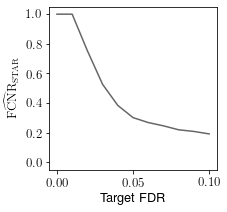

In [512]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fcnps_pexc, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCNR}_{STAR}$")
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat{\mathrm{FCNR}}_\mathrm{STAR}$"); plt.ylim(-0.05,1.05)

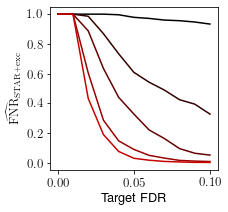

In [520]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fnps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FNR}_\mathrm{STAR+exc}$"); #plt.legend()

In [505]:
np.mean(fcdps_pexc, (1))

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0125    , 0.0125    , 0.0125    , 0.0125    , 0.02083333,
        0.01666667],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00416667, 0.00416667, 0.00416667, 0.00416667,
        0.00416667],
       [0.        , 0.        , 0.        , 0.00333333, 0.        ,
        0.        , 0.00416667, 0.00416667, 0.00416667, 0.00416667,
        0.00416667],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00416667, 0.00416667, 0.00416667,
        0.00416667],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

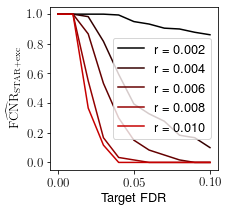

In [521]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcnps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"r = %.3f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FCNR}_\mathrm{STAR+exc}$"); plt.legend()